# ch07 数据规整化：清理、转换、合并、重塑
## 7.1 合并数据集
+ pandas.merge 可根据一个或多个键将不同DataFrame中的行连接起来；
+ pandas.concat 可以沿着一条轴将多个对象堆叠到一起；
+ 实例方法combine_first可以将重复数据编接在一起，用一个对象中的值填充另一个对象中的缺失值。

### 7.1.1 数据库风格的DataFrame合并
merge(left,right,left_on = 'key1',right_on='key2'，how = 'left')

表7-1：merge 函数的参数

| 类型        | 说明                   |
|:------------- |:-------------|
| left    | 参与合并的左侧DataFrame   |
| right     | 参与合并的右侧DataFrame    |
| how    | “inner”、“outer”、“left”、“right”，默认为“inner” |
| on/left_on/right_on   | 用于连接的列名 |
| left_index/right_index  | 将左/右侧的行索引用作其连接键 |
| sort | 默认为True，根据连接对合并后的数据进行排序|
| suffixes | 字符串值元组，用于追加到重叠列名的末尾，默认为('_x','_y') |
| copy | 默认为True，将数据复制到结果数据结构中|

In [1]:
import pandas as pd
df1 = pd.DataFrame({'key':['b','b','a','c','a','a','b'],
                    'data1':range(7)})
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [2]:
df2 = pd.DataFrame({'key':['a','b','d'],
                   'data2':range(3)})
df2

,data2,key
0,0,a
1,1,b
2,2,d


In [3]:
pd.merge(df1,df2) # 不指定连接列会将重叠列的列名当作键
#pd.merge(df1,df2,on='key') # 显示指定

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [4]:
# 显示指定连接键及连接方式
df3 = pd.DataFrame({'lkey':['b','b','a','c','a','a','b'],
                    'data1':range(7)})
df4 = pd.DataFrame({'rkey':['a','b','d'],
                    'data2':range(3)})
pd.merge(df3,df4,left_on='lkey',right_on='rkey',how='outer')

,data1,lkey,data2,rkey
0,0.0,b,1.0,b
1,1.0,b,1.0,b
2,6.0,b,1.0,b
3,2.0,a,0.0,a
4,4.0,a,0.0,a
5,5.0,a,0.0,a
6,3.0,c,NaN,NaN
7,NaN,NaN,2.0,d


In [5]:
# 根据多个键连接 重复列名的处理
left = pd.DataFrame({'key1':['foo','foo','bar'],
                     'key2':['one','two','one'],
                     'val':[1,2,3]})
right = pd.DataFrame({'key1':['foo','foo','bar','bar'],
                      'key2':['one','one','one','two'],
                      'val':[4,5,6,7]})
pd.merge(left,right,on=['key1','key2'],how='outer',suffixes=('_left','_right'))

,key1,key2,val_left,val_right
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


### 7.1.2 索引上的合并

In [6]:
left1 = pd.DataFrame({'key':['a','b','a','a','b','c'],
                      'value':range(6)})
right1 = pd.DataFrame({'group_val':[3.5,7]},index=['a','b'])
pd.merge(left1,right1,left_on='key',right_index=True,how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


In [7]:
# 层次化索引
import numpy as np
lefth = pd.DataFrame({'key1':['Ohio','Ohio','Ohio','Nevada','Nevada'],
                      'key2':[2000,2001,2002,2001,2002],
                      'data':np.arange(5.)})
righth = pd.DataFrame(np.arange(12).reshape((6,2)),
                      index=[['Nevada','Nevada','Ohio','Ohio','Ohio','Ohio'],
                     [2001,2000,2000,2000,2001,2002]],
                      columns=['event1','event2'])
pd.merge(lefth,righth,left_on=['key1','key2'],right_index=True,how='outer')

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,4.0,5.0
0,0.0,Ohio,2000,6.0,7.0
1,1.0,Ohio,2001,8.0,9.0
2,2.0,Ohio,2002,10.0,11.0
3,3.0,Nevada,2001,0.0,1.0
4,4.0,Nevada,2002,NaN,NaN
4,NaN,Nevada,2000,2.0,3.0


In [8]:
# 同时使用双方的索引
left2 = pd.DataFrame([[1.,2.],[3.,4.],[5.,6.]],index=['a','c','e'],
                    columns=['Ohio','Nevada'])
right2 = pd.DataFrame([[7.,8.],[9.,10.],[11.,12.],[13.,14.]],
                      index=['b','c','d','e'],
                      columns=['Missouri','Alabama'])
pd.merge(left2,right2,left_index=True,right_index=True,how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [9]:
# join 实例方法
left2.join(right2,how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [10]:
# DataFrame的join方法是在连续键上做左连接
left1.join(right1,on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


In [11]:
# 简单地索引合并
another = pd.DataFrame([[7.,8.],[9.,10.],[11.,12.],[16.,17.]],
                      index=['a','c','e','f'],columns=['New York','Oregon'])
left2.join([right2,another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [12]:
left2.join([right2,another],how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


### 7.1.3 轴向连接
另一种数据合并运算也被称作连接（concatenation）、绑定（binding）或堆叠（stacking）。

Numpy有一个用于合并原始Numpy数组的concatenation函数：

In [13]:
arr = np.arange(12).reshape((3,4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [14]:
np.concatenate([arr,arr],axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

对于pandas对象（如Series和DataFrame），带有标签的轴使得能够进一步推广数组的连接运算：pandas的concat函数

表7-2：concat 函数的参数

| 类型        | 说明                   |
|:------------- |:-------------|
| objs    | 参与连接的pandas对象的列表或字典，唯一必须的参数   |
| axis     | 指明连接的轴向，默认为0   |
| join    | “inner”、“outer”其中之一，默认为“outer” |
| join_axes   | 指明用于其他n-1条轴的索引，不执行并集/交集运算 |
| keys  | 与连接对象有关的值，用于形成连接轴向上的层次化索引，可以是任意值的列表或数组、元组数组、数组列表（如果将levels设置成多级数组的话 |
| levels | 指定用作层次化索引各级别上的索引，如果设置了keys的话|
| names | 用于创建分层级别的名称，如果设置了keys和（或）levels的话 |
| verify_integrity | 检查结果对象新轴上的重复情况，如果发现则引发异常，默认（False）允许重复|
| ignore_index | 不保留连接轴上的索引，产生一组新索引range(total_length)|

假设有三个没有重叠索引的Series：

In [15]:
s1 = pd.Series([0,1],index=['a','b'])
s2 = pd.Series([2,3,4],index=['c','d','e'])
s3 = pd.Series([5,6],index=['f','g'])
# 默认情况下，concat是在axis=0上工作的，最终产生一个新的Series
pd.concat([s1,s2,s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [16]:
pd.concat([s1,s2,s3],axis = 1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [17]:
s4 = pd.concat([s1 * 5,s3])
pd.concat([s1,s4],axis=1)

,0,1
a,0.0,0
b,1.0,5
f,NaN,5
g,NaN,6


In [18]:
# 交集
pd.concat([s1,s4],axis=1,join = 'inner')

,0,1
a,0,0
b,1,5


In [19]:
# 通过join_axes指定要在其他轴上使用的索引：
pd.concat([s1,s4],axis=1,join_axes = [['a','c','b','e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,5.0
e,NaN,NaN


参与连接的片段在结果中区分不开，假设想要在连接轴上创建一个层次化索引，使用keys这个参数即可：

In [20]:
result = pd.concat([s1,s2,s3],keys=['one','two','three'])
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [21]:
result.unstack()

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


如果沿着axis=1对Series进行合并，则keys就会成为DataFrame的列头：

In [22]:
pd.concat([s1,s2,s3],axis=1,keys=['one','two','three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


同样的逻辑对DataFrame对象也一样：

In [23]:
df1 = pd.DataFrame(np.arange(6).reshape(3,2),index=['a','b','c'],
                  columns=['one','two'])
df2 = pd.DataFrame(5+np.arange(4).reshape(2,2),index=['a','c'],
                  columns=['three','four'])
pd.concat([df1,df2],axis=1,keys=['level1','level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [24]:
# 如果传入的不是列表而是一个字典，则字典的键就会被当作keys选项的值
pd.concat({'level1':df1,'level2':df2},axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [25]:
# 用于管理层次化索引创建方式的参数
pd.concat([df1,df2],axis=1,keys=['level1','level2'],
         names=['upper','lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

In [26]:
df1 = pd.DataFrame(np.random.randn(3,4),columns=['a','b','c','d'])
df2 = pd.DataFrame(np.random.randn(2,3),columns=['b','d','a'])
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,-1.388803,0.360143,-1.655349,-0.343329
1,-0.296703,0.271503,1.312673,-1.172928
2,-2.044488,0.520415,-0.732007,1.783496
3,-0.223162,-1.155679,NaN,1.000451
4,0.376131,-1.476838,NaN,-0.623753


### 7.1.4 合并重叠数据
还有一种数据组合问题不能用简单的合并（merge）或连接（concatenation）运算来处理。比如说，有索引全部或部分重叠的两个数据集：

In [27]:
a = pd.Series([np.nan,2.5,np.nan,3.5,4.5,np.nan],
             index=['f','e','d','c','b','a'])
b = pd.Series(np.arange(len(a),dtype=np.float64),
             index=['f','e','d','c','b','a'])
b[-1]=np.nan
np.where(pd.isnull(a),b,a)

array([ 0. ,  2.5,  2. ,  3.5,  4.5,  nan])

In [28]:
# Series有一个conbine_first方法，实现的也是一样的功能，而且会进行数据对齐：
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

对于DataFrame，combine_first自然也会在列上做同样的事情，因此可以将其看作：用参数对象中的数据为调用者对象的缺失数据“打补丁”：

In [29]:
df1 = pd.DataFrame({'a':[1.,np.nan,5.,np.nan],
                   'b':[np.nan,2.,np.nan,6.],
                   'c':range(2,18,4)})
df2 = pd.DataFrame({'a':[5.,4.,np.nan,3.,7.],
                   'b':[np.nan,3.,4.,6.,8.]})
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 7.2 重塑和轴向旋转
有许多用于重新排列表格型数据的基础运算，这些函数也称作重塑（reshape）或轴向旋转（pivot）运算。
### 7.2.1 重塑层次化索引
层次化索引主要功能有二：
+ stack：将数据的列“旋转”为行；
+ unstack：将数据的行“旋转”为列；

In [30]:
# 行、列索引均为字符串
data = pd.DataFrame(np.arange(6).reshape(2,3),
                   index=pd.Index(['Ohio','Colorado'],name='state'),
                   columns=pd.Index(['one','two','three'],name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [31]:
# 列转换为行得到一个Series
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

In [32]:
# 重排为一个DataFrame
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


默认情况下，stack/unstack操作的是最内层，传入分层级别的编号或名称即可对其他级别进行操作：

In [33]:
result.unstack(0)
#result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [34]:
# unstack不对齐可能会引入缺失数据
s1 = pd.Series([0,1,2,3],index=['a','b','c','d'])
s2 = pd.Series([4,5,6],index=['c','d','e'])
data2 = pd.concat([s1,s2],keys=['one','two'])
data2.unstack() 

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


In [35]:
# stack不对齐会过滤缺失数据
data2.unstack().stack()
#data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

在对DataFrame进行unstack操作时，作为旋转轴的级别将会成为结果中的最低级别：

In [36]:
df = pd.DataFrame({'left':result,
                  'right':result + 5},
                 columns = pd.Index(['left','right'],name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [37]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [38]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

### 7.2.2 将“长格式”旋转为“宽格式”
时间序列数据通常是以所谓的“长格式”（long）或“堆叠格式”（stacked）存储在数据库和CSV中的：

In [39]:
ldata = pd.DataFrame({'date':['1959-03-31 00:00:00']*3+['1959-06-30 00:00:00']*3+['1959-09-30 00:00:00']*3+['1959-12-31 00:00:00']*3,
                     'item':['realgdp','infl','unemp']*4,
                     'value':[2170.349,0.000,5.800]*4})
ldata[:10]

,date,item,value
0,1959-03-31 00:00:00,realgdp,2170.349
1,1959-03-31 00:00:00,infl,0.000
2,1959-03-31 00:00:00,unemp,5.800
3,1959-06-30 00:00:00,realgdp,2170.349
4,1959-06-30 00:00:00,infl,0.000
5,1959-06-30 00:00:00,unemp,5.800
6,1959-09-30 00:00:00,realgdp,2170.349
7,1959-09-30 00:00:00,infl,0.000
8,1959-09-30 00:00:00,unemp,5.800
9,1959-12-31 00:00:00,realgdp,2170.349


In [40]:
# 前两个参数值分别用作行和列索引的列名，最后一个参数值则是用于填充DataFrame的数据列的列名
pivoted = ldata.pivot('date','item','value')
pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31 00:00:00,0.0,2170.349,5.8
1959-06-30 00:00:00,0.0,2170.349,5.8
1959-09-30 00:00:00,0.0,2170.349,5.8
1959-12-31 00:00:00,0.0,2170.349,5.8


In [41]:
# 假设有两个需要参与重塑的数据列
ldata['value2'] = np.random.randn(len(ldata))
ldata[:10]

,date,item,value,value2
0,1959-03-31 00:00:00,realgdp,2170.349,0.055231
1,1959-03-31 00:00:00,infl,0.000,0.655625
2,1959-03-31 00:00:00,unemp,5.800,-0.156196
3,1959-06-30 00:00:00,realgdp,2170.349,-1.141299
4,1959-06-30 00:00:00,infl,0.000,-0.617976
5,1959-06-30 00:00:00,unemp,5.800,1.601996
6,1959-09-30 00:00:00,realgdp,2170.349,0.743631
7,1959-09-30 00:00:00,infl,0.000,0.435929
8,1959-09-30 00:00:00,unemp,5.800,1.938336
9,1959-12-31 00:00:00,realgdp,2170.349,0.746503


In [42]:
# 如果忽略最后一个参数，得到的DataFrame就会带有层次化的列：
pivoted = ldata.pivot('date','item')
pivoted[:5]

value                    value2                    
item                 infl   realgdp unemp      infl   realgdp     unemp
date                                                                   
1959-03-31 00:00:00   0.0  2170.349   5.8  0.655625  0.055231 -0.156196
1959-06-30 00:00:00   0.0  2170.349   5.8 -0.617976 -1.141299  1.601996
1959-09-30 00:00:00   0.0  2170.349   5.8  0.435929  0.743631  1.938336
1959-12-31 00:00:00   0.0  2170.349   5.8 -0.501862  0.746503 -0.387643

In [43]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31 00:00:00,0.0,2170.349,5.8
1959-06-30 00:00:00,0.0,2170.349,5.8
1959-09-30 00:00:00,0.0,2170.349,5.8
1959-12-31 00:00:00,0.0,2170.349,5.8


pivot其实只是一个快捷方式：用set_index创建层次化索引，再用unstack重塑：

In [44]:
unstacked = ldata.set_index(['date','item']).unstack('item')
unstacked

value                    value2                    
item                 infl   realgdp unemp      infl   realgdp     unemp
date                                                                   
1959-03-31 00:00:00   0.0  2170.349   5.8  0.655625  0.055231 -0.156196
1959-06-30 00:00:00   0.0  2170.349   5.8 -0.617976 -1.141299  1.601996
1959-09-30 00:00:00   0.0  2170.349   5.8  0.435929  0.743631  1.938336
1959-12-31 00:00:00   0.0  2170.349   5.8 -0.501862  0.746503 -0.387643

In [45]:
ldata.set_index(['date','item'])

value    value2
date                item                       
1959-03-31 00:00:00 realgdp  2170.349  0.055231
                    infl        0.000  0.655625
                    unemp       5.800 -0.156196
1959-06-30 00:00:00 realgdp  2170.349 -1.141299
                    infl        0.000 -0.617976
                    unemp       5.800  1.601996
1959-09-30 00:00:00 realgdp  2170.349  0.743631
                    infl        0.000  0.435929
                    unemp       5.800  1.938336
1959-12-31 00:00:00 realgdp  2170.349  0.746503
                    infl        0.000 -0.501862
                    unemp       5.800 -0.387643

## 7.3 数据转换
前面介绍的时数据的重排，下面介绍数据的过滤、清理以及其他的转换工作。
### 7.3.1 移除重复数据
DataFrame的duplicted方法返回一个布尔型Series，表示各行是否是重复行；

还有一个drop_duplicates方法返回一个移除了重复行的DataFrame；

In [46]:
data = pd.DataFrame({'k1':['one']*3+['two']*4,
                    'k2':[1,1,2,3,3,4,4]})
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

In [47]:
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


In [48]:
# 可以指定部分列进行重复项判断,
data['v1']=range(7)
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


In [49]:
# 默认保留的是第一个出现的值组合，传入keep='last'则保留最后一个
# keep : {'first', 'last', False}, default 'first'
data.drop_duplicates(['k1','k2'],keep='last')

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


### 7.3.2 利用函数或映射进行数据转换
对数据集进行转换时，希望根据数组、Series或DataFrame列中的值来实现该转换工作：

In [50]:
data = pd.DataFrame({'food':['bacon','pulled pork','bacon','Pastrami',
                            'corned beef','Bacon','pastrami','honey ham','nova lox'],
                    'ounces':[4,3,12,6,7.5,8,3,5,6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


In [51]:
#编写一个肉类到动物的映射
meat_to_animal = {
    'bacon':'pig',
    'pulled pork':'pig',
    'pastrami':'cow',
    'corned beef':'cow',
    'honey ham':'pig',
    'nova lox':'salmon'
}

Series的map方法可以接受一个函数或含有映射关系的字典型对象，但是这里有一个小问题，就是字母大小写问题，因此还需转换为小写：

In [52]:
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


使用map是一种实现元素级转换以及其他数据清理工作的便捷方式；

也可以传入一个能够完成全部这些工作的函数：

In [53]:
data['food'].map(lambda x:meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

### 7.3.3 替换值
利用fillna方法填充缺失数据可以看作值替换的一种特殊情况，replace提供了替换值的简单灵活的方式：

In [54]:
data = pd.Series([1.,-999.,2.,-999.,-1000.,3.])
data.replace(-999,np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

In [55]:
# 一次性替换多个值
data.replace([-999,-1000],np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

In [56]:
# 对不同值进行不同替换
data.replace([-999,-1000],[np.nan,0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

### 7.3.4 重命名轴索引


In [57]:
data = pd.DataFrame(np.arange(12).reshape(3,4),
                   index=['Ohio','Colorado','New York'],
                   columns=['one','two','three','four'])
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [58]:
data.index=data.index.map(str.upper)
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [59]:
# 如果想要创建数据集的转换版（而不是修改原始数据），比较实用的方法是rename
data.rename(index=str.upper,columns=str.title)

,One,Two,Three,Four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [60]:
# rename可以结合字典型对象实现对部分轴标签的更新
data.rename(index={'OHIO':'INDIANA'},
           columns={'three':'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


rename实现的是：复制DataFrame并对其索引和列标签进行赋值，

如果希望就地修改某个数据集，传入inplace=True即可：

In [61]:
# 总是返回DataFrame的引用
_ = data.rename(index={'OHIO':'INDIANA'},inplace=True)
data

,one,two,three,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


### 7.3.5 离散化和面元划分
分析中，连续数据常常被离散化或拆分为“面元”（bin），例如，使用cut函数划分年龄组：

In [62]:
ages = [20,22,25,27,21,23,27,37,31,61,45,41,32]
bins = [18,25,35,60,100]
cats = pd.cut(ages,bins)
cats # 返回的是特殊的Categorical对象
#help(pd.Categorical)

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 13
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

In [63]:
# 含有一个表示不同分类名称的categories数组及一个为年龄数据进行标号的codes属性
cats.codes #  The codes of this categorical, read only
cats.categories # The categories of this categorical
cats.ordered # Whether or not this Categorical is ordered

True

In [64]:
pd.value_counts(cats)

(18, 25]     5
(25, 35]     4
(35, 60]     3
(60, 100]    1
dtype: int64

In [65]:
#设置开闭区间
pd.cut(ages,[18,26,36,61,100],right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 13
Categories (4, interval[int64]): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

In [66]:
#设置bin名称，将labels选项设置为一个列表或数组即可
group_names = ['Youth','YoungAdult','MiddleAged','Senior']
pd.cut(ages,bins,labels = group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 13
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

In [67]:
# 传入bins的数量而不是边界，则会根据数据的最小值和最大值计算等长bins
data = np.random.rand(20)
pd.cut(data,4,precision=2).value_counts()

(0.013, 0.25]    4
(0.25, 0.5]      4
(0.5, 0.74]      4
(0.74, 0.98]     8
dtype: int64

qcut类似cut函数，可以根据样本分位数对数据进行bins划分，可以得到大小基本相等的bins：

In [68]:
data = np.random.randn(1000) # 正态分布
cats = pd.qcut(data,4) # 按四分位数进行切割
cats.value_counts()

(-3.504, -0.655]      250
(-0.655, -0.00126]    250
(-0.00126, 0.681]     250
(0.681, 3.396]        250
dtype: int64

In [69]:
# 设置自定义的分位数
pd.qcut(data,[0,0.1,0.5,0.9,1.]).value_counts()

(-3.504, -1.31]      100
(-1.31, -0.00126]    400
(-0.00126, 1.317]    400
(1.317, 3.396]       100
dtype: int64

### 7.3.6 检测和过滤异常值
异常值（outlier）的过滤或变换运算在很大程度上其实就是数组运算。

In [70]:
np.random.seed(12345)
data = pd.DataFrame(np.random.randn(1000,4))
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


In [71]:
# 找出某列中绝对值大小超过3的值
col = data[3]
col[np.abs(col)>3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

In [72]:
# 选出全部含有“绝对值大于3”的行
data[(np.abs(data)>3).any(1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


In [73]:
# 将值限值在-3到3以内
data[np.abs(data)>3]=np.sign(data)*3
# np.sign 返回的是一个由1和-1组成的数组，表示原始值的符号
data[5:6]

,0,1,2,3
5,-0.539741,0.476985,3.0,-1.021228


### 7.3.7 排列和随机采样
利用numpy.random.permutation函数可以轻松实现对Series或DataFrame的列的排列工作，通过需要排列的轴的长度调用permutation，可产生一个表示新顺序的整数数组：

In [74]:
df = pd.DataFrame(np.arange(5*4).reshape(5,4))
sampler = np.random.permutation(5)
sampler

array([1, 0, 2, 3, 4])

然后在基于ix的索引操作或take函数中使用该数组：

In [75]:
df.take(sampler)

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


如果不想用替换的方式选取随机子集，则可以使用permutation：从permutation返回的数组中切下前k个元素，其中k为期望的子集大小。

In [76]:
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


通过替换的方式产生样本，最快的方式是通过np.random.randint得到一组随机整数：

In [77]:
bag = np.array([5,7,-1,6,4])
sampler = np.random.randint(0,len(bag),size=10)
sampler

array([4, 4, 2, 2, 2, 0, 3, 0, 4, 1])

In [78]:
draws = bag.take(sampler)
draws

array([ 4,  4, -1, -1, -1,  5,  6,  5,  4,  7])

### 7.3.8 计算指标/哑变量
常用于统计建模或机器学习的转换方式：将分类变量（categorical variable）转换为“哑变量矩阵”（dummy matrix）或“指标矩阵”（indicator matrix）。

如果DataFrame的某一列中含有k个不同的值，则可以派生出一个k列矩阵或DataFrame（其值全为1和0）。

pandas有一个get_dummies函数可以实现该功能：

In [79]:
df = pd.DataFrame({'key':['b','b','a','c','a','b'],
                  'data1':range(6)})
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


给指标DataFrame的列加上一个前缀，以便能够跟其他数据进行合并：

In [80]:
dummies = pd.get_dummies(df['key'],prefix='key')
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


如果DataFrame中的某行同属于多个分类，则事情就会有点复杂：

In [81]:
mnames = ['movie_id','title','genres']
movies = pd.read_table('D:\GitHub\python-study\python_for_data_analysis\ml-1m\movies.dat',
                       sep='::',header=None,names=mnames)
movies[:10]

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [82]:
# 为每个genre添加指标变量需做一些数据规整操作
# 首先从数据集中抽取出不同的genre值
genre_iter = (set(x.split('|')) for x in movies.genres)
genres = sorted(set.union(*genre_iter))
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [83]:
# 从一个全零DataFrame开始构建指标DataFrame：
dummies = pd.DataFrame(np.zeros((len(movies),len(genres))),columns=genres)
dummies[:3]

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# 迭代每一部电影并将dummies各行的项设置为1
for i,gen in enumerate(movies.genres):
    dummies.loc[i,gen.split('|')] = 1
dummies[:3]

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [85]:
# 再将其与movie合并起来
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.iloc[0]

movie_id                                       1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Action                                   0
Genre_Adventure                                0
Genre_Animation                                1
Genre_Children's                               1
Genre_Comedy                                   1
Genre_Crime                                    0
Genre_Documentary                              0
Genre_Drama                                    0
Genre_Fantasy                                  0
Genre_Film-Noir                                0
Genre_Horror                                   0
Genre_Musical                                  0
Genre_Mystery                                  0
Genre_Romance                                  0
Genre_Sci-Fi                                   0
Genre_Thriller                                 0
Genre_War                                      0
Genre_Western       

对于很大的数据，用这种方式构建多成员指标变量就会变得非常慢，肯定需要编写一个能够利用DataFrame内部机制的更低级的函数才行；

一个对统计应用有用的秘诀是：结合get_dummies和诸如cut之类的离散化函数：

In [86]:
values = np.random.rand(10)
values

array([ 0.75603383,  0.90830844,  0.96588737,  0.17373658,  0.87592824,
        0.75415641,  0.163486  ,  0.23784062,  0.85564381,  0.58743194])

In [87]:
bins = [0,0.2,0.4,0.6,0.8,1]
pd.get_dummies(pd.cut(values,bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
5,0,0,0,1,0
6,1,0,0,0,0
7,0,1,0,0,0
8,0,0,0,0,1
9,0,0,1,0,0


## 7.4 字符串操作
### 7.4.1 字符串对象方法
对大部分字符串处理应用而言，内置的字符串方法已经能够满足要求：

表7-3：Python内置字符串方法

| 方法        | 说明                   |
|:------------- |:-------------|
| count | 返回子串在字符串中的出现次数   |
| endswith/startswith | 如果字符串以某个后缀结尾/开头则返回True |
| join | 将字符串用作连接其他字符串序列的分隔符 |
| index | 如果在字符串中找到子串，则返回第一个发现的子串的第一个字符所在的位置，如果没有则引发ValueError |
| find  | 如果在字符串中找到子串，则返回第一个发现的子串的第一个字符所在的位置，如果没有则返回-1 |
| rfind  | 如果在字符串中找到子串，则返回最后发现的子串的第一个字符所在的位置，如果没有则返回-1 |
| replace | 用另一个字符串替换指定子串 |
| strip/rstrip/lstrip | 去除空白符（包括换行符） |
| split | 通过指定的分隔符将字符串拆分为一组子串|
| lower/upper | 分别将字母转换为小写或大写|
| ljust/rjust | 用空格（或其他字符）填充字符串的空白侧以返回符合最低宽度的字符串|


In [89]:
# 以逗号分隔的字符串可以用split拆分成数段
val = 'a,b, guido'
val.split(',')

['a', 'b', ' guido']

In [90]:
# spit经常结合strip（用于修剪空白符（包括换行符））一起使用：
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

In [92]:
# 利用加法，可以将这些子字符串以双冒号分隔符的形式连接起来
first,second,third = pieces
first+'::'+second+'::'+third

'a::b::guido'

In [94]:
# 更快的方式是向字符串“：：”的join方法传入一个列表或元组
'::'.join(pieces)

'a::b::guido'

In [95]:
#子串定位 in方法
'guido' in pieces

True

In [96]:
val.index(',')

1

In [97]:
val.find(':') # find和index区别：如果找不到字符串，index会引发一个异常，find会返回一个-1

-1

In [98]:
# count函数返回指定子串出现的次数
val.count(',')

2

In [100]:
# replace用于将指定模式替换为另一个模式，也常常用于删除模式，传入空字符串
# val.replace(',','::')
val.replace(',','')

'ab guido'

### 7.4.2 正则表达式
通常称作regex，提供了一种灵活的在文本中搜索或匹配字符串模式的方式，Python内置的re模块负责对字符串应用正则表达式，re模块的函数分为三大类：模式匹配、替换以及拆分；

表7-4：正则表达式方法

| 方法        | 说明                   |
|:------------- |:-------------|
| findall/finditer | 返回字符串中所有的非重叠匹配模式；findall返回的是由所有模式组成的列表，而finditer则通过一个迭代器逐个返回  |
| match | 从字符串起始位置匹配模式，还可以对模式各部分进行分组，如果匹配到模式，则返回一个匹配对象，否则返回None |
| search | 扫描整个字符串以匹配模式，如果找到则返回一个匹配项对象，跟match不同，其匹配项可以位于字符串的任意位置，而不仅仅是起始处 |
| split | 根据找到的模式将字符串拆分为数段 |
| sub/subn | 将字符串中所有的（sub）或前n个（subn）模式替换为指定表达式。在替换字符串中可以通过\1、\2等符号表示各分组项 |

In [101]:
# 拆分一个字符串，分隔符为数量不定的一组空白符
# 描述一个或多个空白符的regex是\s+
import re
text = "foo  bar\t baz   \tqux"
re.split('\s+',text)

['foo', 'bar', 'baz', 'qux']

调用re.split('\s+',text)时，正则表达式会先被编译，然后再在text上调用其split方法；

可以用re.compile自己编译regex以得到一个可用的regex对象：

In [104]:
regex = re.compile('\s+')
regex.split(text)

['foo', 'bar', 'baz', 'qux']

In [105]:
# 如果只希望得到匹配regex的所有模式
regex.findall(text)

['  ', '\t ', '   \t']

如果想避免正则表达式中不需要的转义（\），则可以使用原始字符串字面量如 r'C:\X'（也可以编写其等价式'C:\\\x'。

如果想对许多字符串应用同一条正则表达式，建议通过re.compile创建regex对象，可以节省大量的CPU时间；

match和search跟findall功能类似，findall返回的是字符串中所有的匹配项，而search则只返回第一个匹配项，match更加严格，只匹配字符串的首部：

In [106]:
# 有一段文本以及一条能够识别大部分电子邮件地址的正则表达式
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com"""
pattern = r'[A-Z0-9._%+-]+@[a-z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE的作用是使正则表达式对大小写不敏感
regex = re.compile(pattern,flags=re.IGNORECASE)
# 对text使用findall得到一组电子邮件地址
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

In [107]:
#search返回的使文本中第一个电子邮件地址（以特殊的匹配项对象形式返回），
#对于上面那个regex，匹配项对象只能告诉模式在原字符串中的起始和结束位置：
m = regex.search(text)
m

In [108]:
text[m.start():m.end()]

'dave@google.com'

In [109]:
# regex.match则将返回None，因为它只匹配出现在字符串开头的模式
print regex.match(text)

None


In [110]:
# 另外还有一个sub方法，它会将匹配到的模式替换为指定字符串，并返回所得到的新字符串
print regex.sub('REDACTED',text)

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED


假设想将各个地址分成3个部分：用户名、域名以及域后缀，只需将待分段的模式的各部分用圆括号包起来即可：

In [111]:
pattern = r'([A-Z0-9._%+-]+)@([a-z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern,flags=re.IGNORECASE)
#由这种正则表达式所产生的匹配对象，可以通过其groups方法返回一个由模式各段组成的元组：
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

In [112]:
# 对于带有分组功能的模式，findall会返回一个元组列表：
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

In [115]:
# sub还能通过诸如\1、\2之类的特殊符号访问各匹配项中的分组
print regex.sub(r' Username:\1, Domain:\2, Suffix:\3',text)

Dave  Username:dave, Domain:google, Suffix:com
Steve  Username:steve, Domain:gmail, Suffix:com
Rob  Username:rob, Domain:gmail, Suffix:com
Ryan  Username:ryan, Domain:yahoo, Suffix:com


In [116]:
# 得到一个简单易用的带有分组名称的字典
regex = re.compile(r"""
(?P<username>[A-Z0-9._%+-]+)
@
(?P<domain>[A-Z0-9.-]+)
\.
(?P<suffix>[A-Z]{2,4})""",flags=re.IGNORECASE|re.VERBOSE)

m = regex.match('wesm@bright.net')
m.groupdict()

{'domain': 'bright', 'suffix': 'net', 'username': 'wesm'}

### 7.4.3 pandas中矢量化的字符串函数
清理待分析的散乱数据时，常常要做一些字符串规整化工作；更为复杂的情况是，含有字符串的列有时还含有缺失数据：

表7-5：矢量化的字符串方法

| 方法        | 说明                   |
|:------------- |:-------------|
| cat | 实现元素级的字符串连接操作，可指定分隔符  |
| contains | 返回表示各字符串是否含有指定模式的布尔型数组  |
| count | 模式的出现次数   |
| endswith/startswith | 相当于对各个元素执行x.endwith(pattern)或x.startswith(pattern) |
| findall | 计算各字符串的模式列表  |
| get | 获取各元素的第i个字符  |
| join | 根据指定的分隔符将Series中各元素的字符串连接起来 |
| len | 计算各字符串的长度  |
| lower/upper | 转换大小写，相当于对各个元素执行x.lower()或x.upper()|
| match | 根据指定的正则表达式对各个元素执行re.match  |
| pad | 在字符串的左边、右边或左右两边添加空白符  |
| center | 相当于pad（side='both')  |
| repeat | 重复值，例如s.str.repeat(3)相当于对各个字符串执行x\*3 |
| replace | 用指定字符串替换找到的模式 |
| slice | 对Series中的各个字符串进行子串截取  |
| split | 根据分隔符或正则表达式对字符串进行拆分  |
| strip/rstrip/lstrip | 去除空白符（包括换行符），相当于对各个元素执行x.strip()、x.rstrip()、x.lstrip() |

In [118]:
data = {'Dave':'dave@google.com',
       'Steve':'steve@gmail.com',
       'Rob':'rob@gmail.com',
       'Wes':np.nan}
data = pd.Series(data)
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [119]:
data.isnull()

Dave     False
Rob      False
Steve    False
Wes       True
dtype: bool

通过data.map，所有字符串和正则表达式方法都能被应用于（传入lambda表达式或其他函数）各个值，但是如果存在NA就会报错。

为了解决这个问题，Series有一些能够跳过NA值的字符串操作方法，通过Series的str属性即可访问这些方法:

In [121]:
# str.contains可以检查各个电子邮件地址是否含有“gmail”
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

In [122]:
# 也可以使用正则表达式，还可以加上任意re选项（如IGNORECASE）
pattern

'([A-Z0-9._%+-]+)@([a-z0-9.-]+)\\.([A-Z]{2,4})'

In [123]:
data.str.findall(pattern,flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

有两个办法可以实现矢量化的元素获取操作：要么使用str.get,要么在str属性上使用索引：

In [136]:
matches = data.str.match(pattern,flags=re.IGNORECASE)
matches
#matches.str.get(1)
#matches.str[1]

Dave     True
Rob      True
Steve    True
Wes       NaN
dtype: object

In [131]:
# 对字符串进行子串截取
data.str[:5]

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object

## 7.5 示例：USDA食品数据库
数据为json格式，每种食物都带有若干标识性属性以及两个有关营养成分和分量的列表，这种形式的数据不是很适合分析工作，因此需要做一些规整化。

下载数据后可以用任何json库将其加载到Python中，示例使用Python内置的json模块：

In [138]:
import json
db = json.load(open(r'D:\GitHub\python-study\python_for_data_analysis\book-code\ch07\foods-2011-10-03.json'))
len(db)

6636

db中的每个条目都是一个含有某种食物全部数据的字典。nutrients字段是一个字典列表，其中每个字典对应一种营养成分：

In [142]:
db[0].keys()

[u'portions',
 u'description',
 u'tags',
 u'nutrients',
 u'group',
 u'id',
 u'manufacturer']

In [147]:
db[0]['nutrients'][0]

{u'description': u'Protein',
 u'group': u'Composition',
 u'units': u'g',
 u'value': 25.18}

In [152]:
nutrients = pd.DataFrame(db[0]['nutrients'])
nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


将字典列表转换为DataFrame时，可以只抽取其中的一部分字段，这里我们将取出食物的名称、分类、编号以及制造商等信息：

In [153]:
info_keys = ['description','group','id','manufacturer']
info = pd.DataFrame(db,columns=info_keys)
info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [155]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.4+ KB


In [156]:
# 查看食物类别的分布情况
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

为了对全部营养数据做一些分析，最简单的办法是将所有食物的营养成分整合到一个大表中：

In [157]:
nutrients = []
for rec in db:
    fnuts = pd.DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

In [161]:
nutrients = pd.concat(nutrients,ignore_index=True)
nutrients[:7]

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008
5,Water,Composition,g,39.28,1008
6,Energy,Energy,kJ,1573.00,1008


In [162]:
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389355 entries, 0 to 389354
Data columns (total 5 columns):
description    389355 non-null object
group          389355 non-null object
units          389355 non-null object
value          389355 non-null float64
id             389355 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.9+ MB


In [165]:
# 丢弃重复项
nutrients.duplicated().sum()

14179

In [166]:
nutrients = nutrients.drop_duplicates()

由于两个DataFrame对象中都有“group”和“description”，需要重命名：

In [167]:
col_mapping = {'description':'food',
              'group':'fgroup'}
info = info.rename(columns=col_mapping,copy=False)
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
food            6636 non-null object
fgroup          6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.4+ KB


In [168]:
col_mapping = {'description':'nutrient',
              'group':'nutgroup'}
nutrients = nutrients.rename(columns=col_mapping,copy=False)
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 389354
Data columns (total 5 columns):
nutrient    375176 non-null object
nutgroup    375176 non-null object
units       375176 non-null object
value       375176 non-null float64
id          375176 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.2+ MB


合并info跟nutrients：

In [170]:
ndata = pd.merge(nutrients,info,on='id',how='outer')
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
nutrient        375176 non-null object
nutgroup        375176 non-null object
units           375176 non-null object
value           375176 non-null float64
id              375176 non-null int64
food            375176 non-null object
fgroup          375176 non-null object
manufacturer    293054 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [171]:
ndata.iloc[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

下面时接下来章节会学习的内容，比如，可以根据食物分类和营养类型画出一张中位值图：

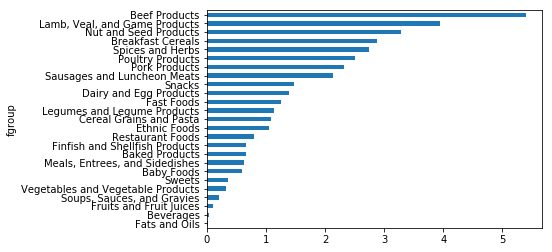

In [184]:
result = ndata.groupby(['nutrient','fgroup'])['value'].quantile(0.5)
%matplotlib inline
result['Zinc, Zn'].sort_values().plot(kind='barh')

发现各营养成分最为丰富的食物：

In [190]:
by_nutrient = ndata.groupby(['nutgroup','nutrient'])

get_maximum = lambda x:x.xs(x.value.idxmax())
get_minimum = lambda x:x.xs(x.value.idxmin())

max_foods = by_nutrient.apply(get_maximum)[['value','food']]
# 让food小一点
max_foods.food = max_foods.food.str[:50]
max_foods.loc['Amino Acids']['food']

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 